In [1]:
# Step 1: Import libraries
import os
import wfdb
import pandoc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import scipy.signal as spsig
from imblearn.over_sampling import SMOTE
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report

In [2]:
base_path = "/Users/mohithreddy/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0"

In [3]:
import zipfile, os

zip_path = "/Users/mohithreddy/Downloads/mit-bih-arrhythmia-database-1.0.0.zip"  
extract_dir = "/Users/mohithreddy/mit-bih-arrhythmia-database-1.0.0"

# Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted to:", extract_dir)
print("Files inside:", os.listdir(extract_dir)[:10])

Extracted to: /Users/mohithreddy/mit-bih-arrhythmia-database-1.0.0
Files inside: ['mit-bih-arrhythmia-database-1.0.0']


In [4]:
os.getcwd()

'/Users/mohithreddy'

In [5]:
os.listdir("mit-bih-arrhythmia-database-1.0.0")[:10]

['mit-bih-arrhythmia-database-1.0.0']

In [6]:
# Adjust path one level deeper
data_path = "mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0"

In [7]:
os.listdir(data_path)[:10]

['209.hea',
 '221.hea',
 '213.dat',
 '207.dat',
 '102.xws',
 '116.xws',
 '118.atr',
 '124.atr',
 '117.xws',
 '119.atr']

In [8]:
data_path = "/Users/mohithreddy/Downloads/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0"

In [9]:
# Folder where you extracted the dataset
data_path = "mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0"

records = {}
for rec in ['114', '124', '202', '221', '102']:
    record = wfdb.rdrecord(os.path.join(data_path, rec))
    annotation = wfdb.rdann(os.path.join(data_path, rec), 'atr')
    records[rec] = {
        "signal": record.p_signal[:, 0],
        "ann": annotation,
        "fs": record.fs          
    }
    print(f"Loaded record {rec} with {len(record.p_signal)} samples at {record.fs} Hz.")



Loaded record 114 with 650000 samples at 360 Hz.
Loaded record 124 with 650000 samples at 360 Hz.
Loaded record 202 with 650000 samples at 360 Hz.
Loaded record 221 with 650000 samples at 360 Hz.
Loaded record 102 with 650000 samples at 360 Hz.


In [10]:
def bandpass_filter(ecg, fs, low=0.5, high=50, order=4):
    nyquist = 0.5 * fs
    b, a = butter(order, [low / nyquist, high / nyquist], btype='band')
    return filtfilt(b, a, ecg)

# Apply the filter to all subjects
for rec in records:
    fs = records[rec]['fs']
    records[rec]['filtered'] = bandpass_filter(records[rec]['signal'], fs)
    print(f"Filtered {rec}")


Filtered 114
Filtered 124
Filtered 202
Filtered 221
Filtered 102


In [11]:
NORMAL = ['N', 'L', 'R']
ARRHYTHMIA = ['A', 'V', 'F', 'E']

def label_beats(annotation):
    symbols = np.array(annotation.symbol)
    samples = np.array(annotation.sample)
    mask = np.isin(symbols, NORMAL + ARRHYTHMIA)
    symbols, samples = symbols[mask], samples[mask]
    labels = np.array([0 if s in NORMAL else 1 for s in symbols])
    return labels, samples


In [12]:
def segment_signal(ecg, fs, window_sec=3, overlap_sec=0.5):
    win_len = int(window_sec * fs)
    step = int((window_sec - overlap_sec) * fs)
    return [ecg[i:i+win_len] for i in range(0, len(ecg)-win_len, step)]


def assign_labels_to_windows(annotation, fs, signal_len, window_sec=3, overlap_sec=0.5):
    labels, samples = label_beats(annotation)
    win_len = int(window_sec * fs)
    step = int((window_sec - overlap_sec) * fs)
    win_labels = []
    for start in range(0, signal_len - win_len, step):
        end = start + win_len
        beat_labels = labels[(samples >= start) & (samples < end)]
        if len(beat_labels) == 0:
            win_labels.append(None)
        else:
            win_labels.append(int(np.mean(beat_labels) > 0.5))
    return np.array(win_labels)


In [13]:
data_path = "mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0"
subjects = ['114', '124', '202', '221', '102']

for rec in subjects:
    ann = wfdb.rdann(os.path.join(data_path, rec), "atr")  # Load annotation file
    labels, samples = label_beats(ann)
    
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Subject {rec} — Label Distribution:")
    for u, c in zip(unique, counts):
        label_name = "Normal" if u == 0 else "Arrhythmia"
        print(f"   {label_name}: {c}")
    print("-" * 40)

Subject 114 — Label Distribution:
   Normal: 1820
   Arrhythmia: 57
----------------------------------------
Subject 124 — Label Distribution:
   Normal: 1531
   Arrhythmia: 54
----------------------------------------
Subject 202 — Label Distribution:
   Normal: 2061
   Arrhythmia: 56
----------------------------------------
Subject 221 — Label Distribution:
   Normal: 2031
   Arrhythmia: 396
----------------------------------------
Subject 102 — Label Distribution:
   Normal: 99
   Arrhythmia: 4
----------------------------------------


In [14]:
fs = 360  # sampling frequency
signal = records['114']['signal']  # example subject
window_sizes = [1, 2, 3, 4, 5]  # in seconds
overlap = 0.5  # in seconds


Total segments for 114: 722


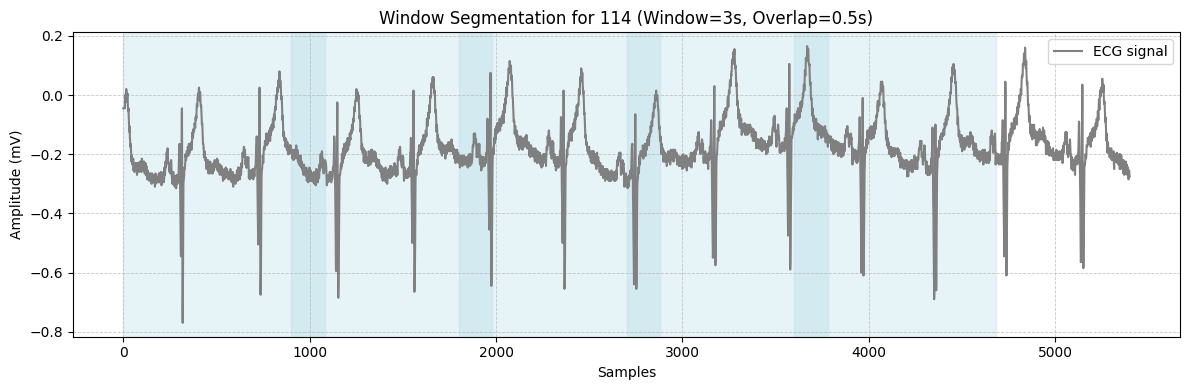

Total segments for 124: 722


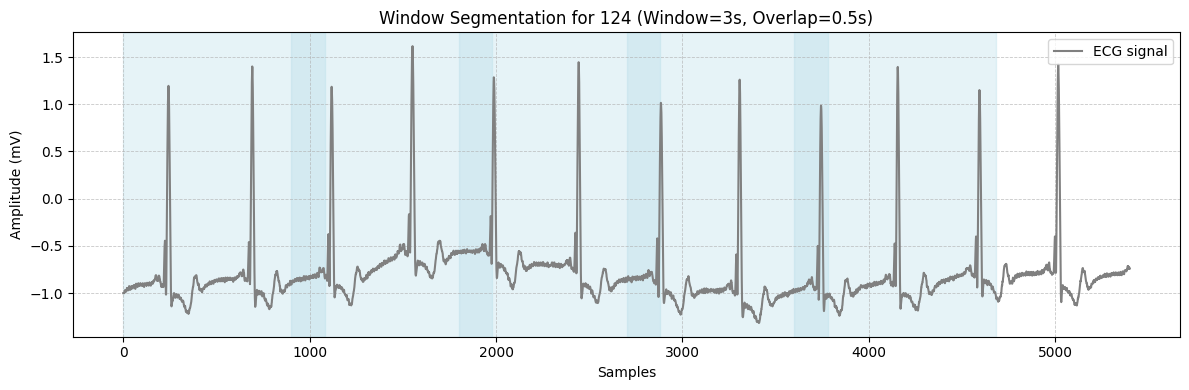

Total segments for 202: 722


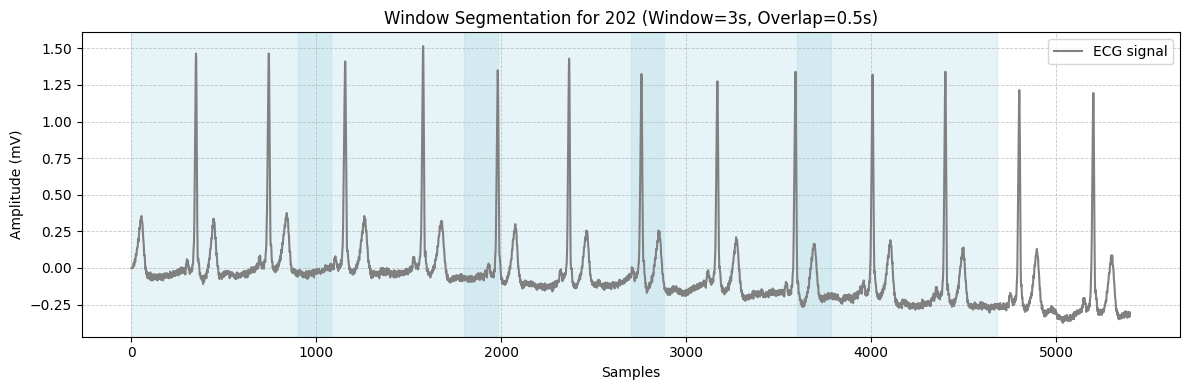

Total segments for 221: 722


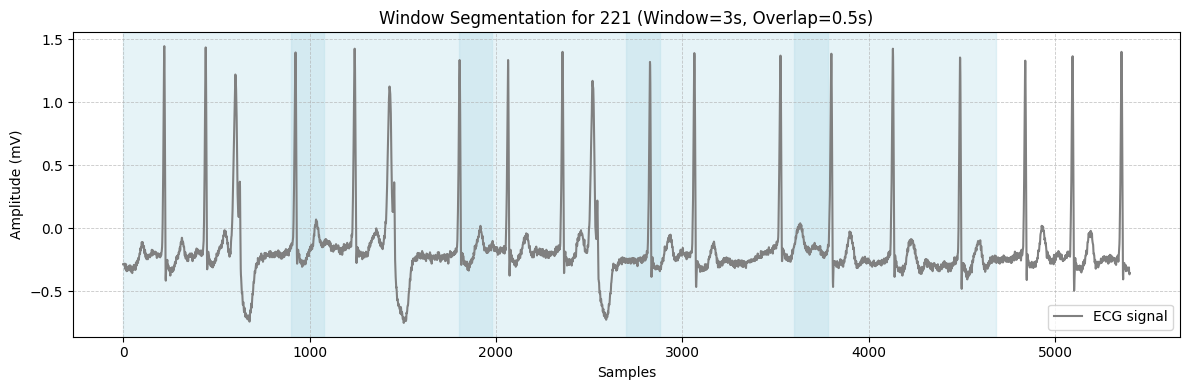

Total segments for 102: 722


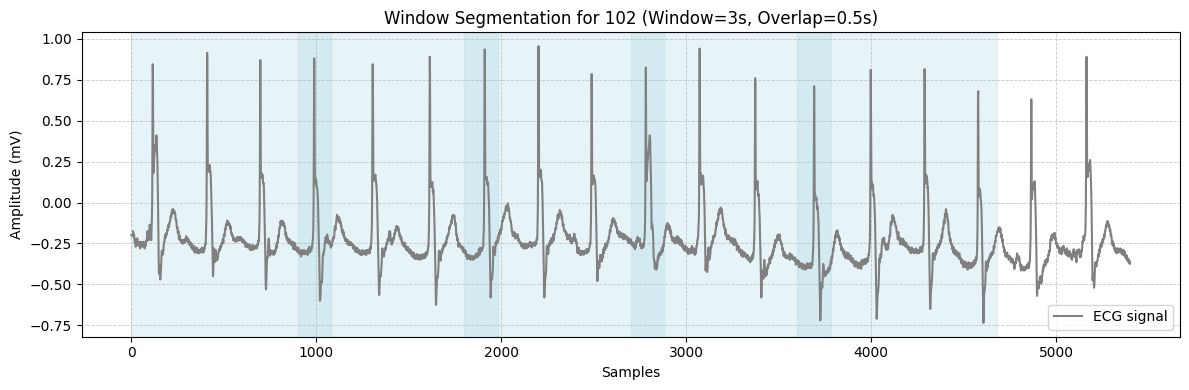

In [15]:
window_sec = 3   # seconds per window
overlap_sec = 0.5   # seconds overlap

def plot_windows(signal, fs, ws, overlap, subject):
    plt.figure(figsize=(12, 4))
    plt.plot(signal[:fs*15], color='gray', label='ECG signal')

    # Draw segmentation spans
    step = int(fs * (ws - overlap))
    for i in range(0, int(fs*15 - fs*ws), step):
        plt.axvspan(i, i + fs*ws, color='lightblue', alpha=0.3)

    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

    # Add titles and labels
    plt.title(f'Window Segmentation for {subject} (Window={ws}s, Overlap={overlap}s)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    plt.tight_layout()
    plt.show()

for subj in subjects:
    sig = records[subj]['signal']
    fs = records[subj]['fs']

    # Perform segmentation
    segments = segment_signal(sig, fs, window_sec, overlap_sec)

    # Print total number of segments
    print(f"Total segments for {subj}: {len(segments)}")

    # Visualize window segmentation
    plot_windows(sig, fs, window_sec, overlap_sec, subj)

In [16]:
# Dictionary to store results: {subject: {window_size: count}}
window_counts_all = {}

for rec in subjects:
    signal = records[rec]['signal']
    counts = {}
    for ws in window_sizes:
        segs = segment_signal(signal, fs, ws, overlap)
        counts[ws] = len(segs)
        print(f"Subject {rec} - Window {ws}s -> {len(segs)} segments")
    window_counts_all[rec] = counts
    print("-" * 50)

# --- Convert to DataFrame for plotting ---
window_df = pd.DataFrame(window_counts_all).T  # rows = subjects, cols = window sizes
window_df

Subject 114 - Window 1s -> 3610 segments
Subject 114 - Window 2s -> 1203 segments
Subject 114 - Window 3s -> 722 segments
Subject 114 - Window 4s -> 515 segments
Subject 114 - Window 5s -> 401 segments
--------------------------------------------------
Subject 124 - Window 1s -> 3610 segments
Subject 124 - Window 2s -> 1203 segments
Subject 124 - Window 3s -> 722 segments
Subject 124 - Window 4s -> 515 segments
Subject 124 - Window 5s -> 401 segments
--------------------------------------------------
Subject 202 - Window 1s -> 3610 segments
Subject 202 - Window 2s -> 1203 segments
Subject 202 - Window 3s -> 722 segments
Subject 202 - Window 4s -> 515 segments
Subject 202 - Window 5s -> 401 segments
--------------------------------------------------
Subject 221 - Window 1s -> 3610 segments
Subject 221 - Window 2s -> 1203 segments
Subject 221 - Window 3s -> 722 segments
Subject 221 - Window 4s -> 515 segments
Subject 221 - Window 5s -> 401 segments
---------------------------------------

,1,2,3,4,5
114,3610,1203,722,515,401
124,3610,1203,722,515,401
202,3610,1203,722,515,401
221,3610,1203,722,515,401
102,3610,1203,722,515,401


In [17]:
def stability_analysis(signal, fs, window_lengths, overlaps):
    stability = {}
    for ws in window_lengths:
        for ov in overlaps:
            if ov >= ws:
                # Skip if overlap >= window
                continue
            segments = segment_signal(signal, fs, ws, ov)
            means = [np.mean(s) for s in segments]
            stability[(ws, ov)] = np.std(means)
    return stability

window_lengths = [1, 2, 3, 4, 5]
overlaps = [1, 2, 5, 10]

for subj in subjects:
    sig = records[subj]['signal']
    fs = records[subj]['fs']

    stability = stability_analysis(sig, fs, window_lengths, overlaps)

    # Convert to DataFrame
    stab_df = pd.DataFrame(list(stability.items()), columns=['(window, overlap)', 'std_mean'])

    print(f"\nSubject: {subj}")
    print(stab_df.head())


Subject: 114
  (window, overlap)  std_mean
0            (2, 1)  0.101267
1            (3, 1)  0.095575
2            (3, 2)  0.094972
3            (4, 1)  0.089020
4            (4, 2)  0.089374

Subject: 124
  (window, overlap)  std_mean
0            (2, 1)  0.242635
1            (3, 1)  0.224241
2            (3, 2)  0.225006
3            (4, 1)  0.208120
4            (4, 2)  0.208260

Subject: 202
  (window, overlap)  std_mean
0            (2, 1)  0.097152
1            (3, 1)  0.086416
2            (3, 2)  0.086136
3            (4, 1)  0.080156
4            (4, 2)  0.079006

Subject: 221
  (window, overlap)  std_mean
0            (2, 1)  0.068501
1            (3, 1)  0.063737
2            (3, 2)  0.064125
3            (4, 1)  0.061848
4            (4, 2)  0.061634

Subject: 102
  (window, overlap)  std_mean
0            (2, 1)  0.046616
1            (3, 1)  0.043036
2            (3, 2)  0.043244
3            (4, 1)  0.040543
4            (4, 2)  0.040219


In [18]:
def extract_features(windows, fs):
    feats = []
    for w in windows:
        # Time-domain features
        min_val = np.min(w)
        max_val = np.max(w)
        amp = max_val - min_val
        mean_val = np.mean(w)
        std_val = np.std(w)
        med_val = np.median(w)
        skew_val = skew(w)
        kurt_val = kurtosis(w)

        # Frequency-domain features
        freqs = rfftfreq(len(w), 1/fs)
        spectrum = np.abs(rfft(w))
        dom_freq = freqs[np.argmax(spectrum)]
        spec_power = np.sum(spectrum**2)
        spec_entropy = -np.sum((spectrum/spec_power) * np.log(spectrum/spec_power + 1e-10))

        # HRV features
        peaks, _ = find_peaks(w, distance=fs*0.4)
        rr = np.diff(peaks)/fs if len(peaks) > 1 else [0]
        mean_rr = np.mean(rr)
        sdnn = np.std(rr)
        rmssd = np.sqrt(np.mean(np.square(np.diff(rr)))) if len(rr) > 2 else 0

        feats.append([
            min_val, max_val, amp, mean_val, std_val, med_val, skew_val, kurt_val,
            dom_freq, spec_power, spec_entropy, mean_rr, sdnn, rmssd
        ])

    cols = ['Min', 'Max', 'Amplitude', 'Mean', 'Std', 'Median', 'Skew', 'Kurtosis',
            'DomFreq', 'Power', 'Entropy', 'MeanRR', 'SDNN', 'RMSSD']
    return pd.DataFrame(feats, columns=cols)

In [19]:

fs = 360              # sampling frequency
window_size = 3       # seconds
overlap = 0.5         # seconds

subjects = ['114', '124', '202', '221', '102']
all_feature_tables = []

for rec in subjects:
    signal = records[rec]['signal']
    windows = segment_signal(signal, fs, window_size, overlap)
    df_feat = extract_features(windows, fs)
    df_feat['Subject_ID'] = rec
    all_feature_tables.append(df_feat)
    print(f" Record {rec}: {df_feat.shape[0]} windows × {df_feat.shape[1]} features extracted")

# Combine all subjects into one table
combined_features = pd.concat(all_feature_tables, ignore_index=True)
print(f"\nFinal combined feature table shape: {combined_features.shape}")


 Record 114: 722 windows × 15 features extracted
 Record 124: 722 windows × 15 features extracted
 Record 202: 722 windows × 15 features extracted
 Record 221: 722 windows × 15 features extracted
 Record 102: 722 windows × 15 features extracted

Final combined feature table shape: (3610, 15)


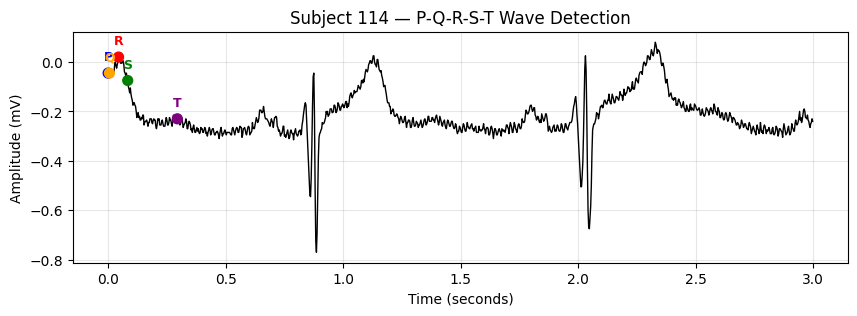

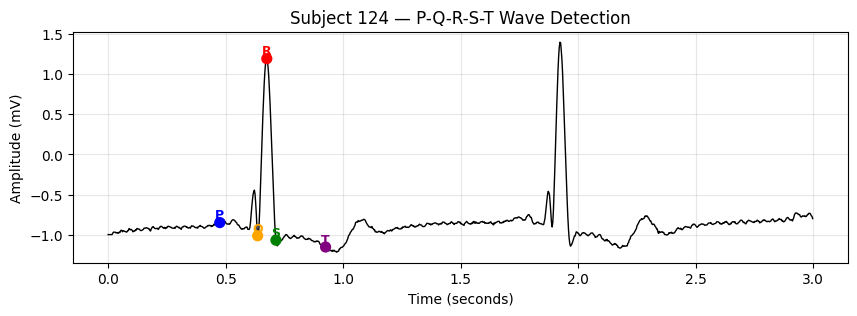

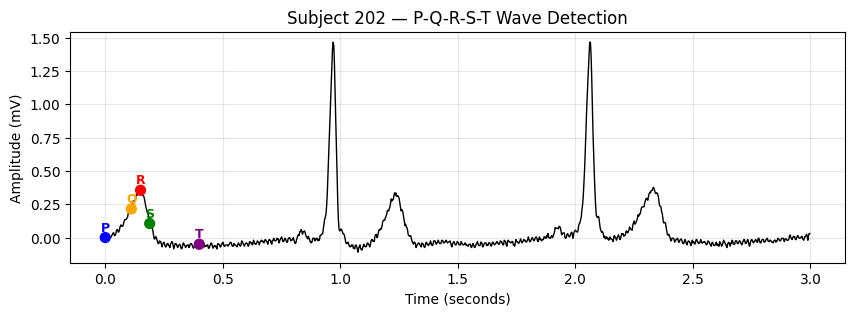

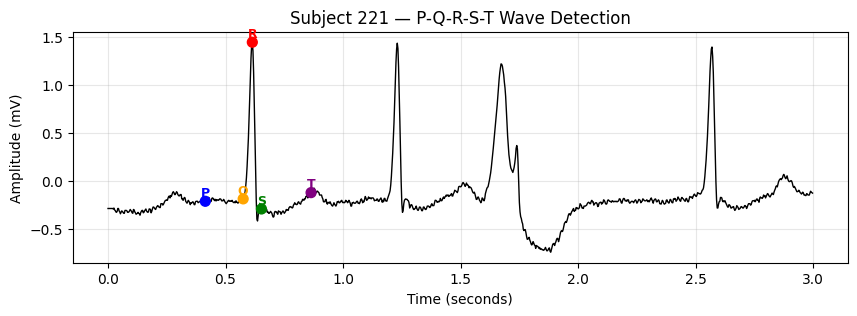

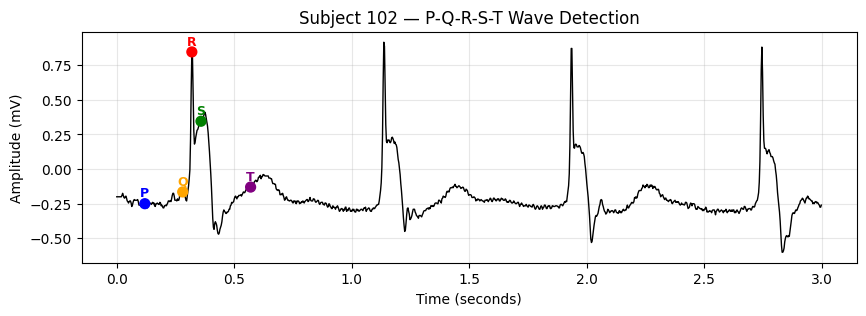


Extracted PQRST Amplitude and Interval Features for 5 Subjects:

  Subject_ID  P_amp  Q_amp  R_amp  S_amp  T_amp  PR_interval  QRS_duration  \
0        114 -0.045 -0.045  0.020 -0.075 -0.230       0.0444        0.0778   
1        124 -0.850 -1.015  1.195 -1.070 -1.155       0.2000        0.0778   
2        202  0.000  0.215  0.355  0.105 -0.050       0.1500        0.0778   
3        221 -0.210 -0.185  1.445 -0.290 -0.120       0.2000        0.0778   
4        102 -0.250 -0.165  0.845  0.345 -0.130       0.2000        0.0778   

   QT_interval  
0       0.2889  
1       0.2889  
2       0.2889  
3       0.2889  
4       0.2889  


In [20]:
fs = 360  # sampling frequency (Hz)

def analyze_and_plot_pqrst(signal, fs, subject_id, duration=3):
    """
    Detects P, Q, R, S, and T waves in an ECG signal segment,
    plots them, and returns amplitude & interval features.
    """
    segment = signal[:fs*duration]
    time_axis = np.arange(len(segment)) / fs

    # Detect R-peaks (dominant spikes)
    r_peaks, _ = find_peaks(segment, distance=fs*0.4, height=np.mean(segment)+0.2*np.std(segment))

    # Initialize
    p_amp = q_amp = r_amp = s_amp = t_amp = np.nan
    pr_interval = qrs_duration = qt_interval = np.nan
    p_idx = q_idx = r_idx = s_idx = t_idx = None

    if len(r_peaks) > 0:
        r_idx = r_peaks[0]
        r_amp = segment[r_idx]

        # Approximate other wave positions relative to R
        p_idx = max(0, r_idx - int(0.2 * fs))
        q_idx = max(0, r_idx - int(0.04 * fs))
        s_idx = min(len(segment) - 1, r_idx + int(0.04 * fs))
        t_idx = min(len(segment) - 1, r_idx + int(0.25 * fs))

        p_amp, q_amp, s_amp, t_amp = segment[p_idx], segment[q_idx], segment[s_idx], segment[t_idx]

        pr_interval = (r_idx - p_idx) / fs
        qrs_duration = (s_idx - q_idx) / fs
        qt_interval = (t_idx - q_idx) / fs

        plt.figure(figsize=(10, 3))
        plt.plot(time_axis, segment, color='black', linewidth=1)
        plt.title(f"Subject {subject_id} — P-Q-R-S-T Wave Detection")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (mV)")
        plt.grid(alpha=0.3)

        plt.scatter(time_axis[[p_idx, q_idx, r_idx, s_idx, t_idx]],
                    segment[[p_idx, q_idx, r_idx, s_idx, t_idx]],
                    color=['blue', 'orange', 'red', 'green', 'purple'],
                    s=50, zorder=3)

        labels = ['P', 'Q', 'R', 'S', 'T']
        for idx, label, color in zip([p_idx, q_idx, r_idx, s_idx, t_idx],
                                     labels,
                                     ['blue', 'orange', 'red', 'green', 'purple']):
            plt.text(time_axis[idx], segment[idx] + 0.05, label,
                     color=color, fontsize=9, ha='center', fontweight='bold')
        plt.show()

    # Return numerical features
    return {
        'Subject_ID': subject_id,
        'P_amp': p_amp, 'Q_amp': q_amp, 'R_amp': r_amp, 'S_amp': s_amp, 'T_amp': t_amp,
        'PR_interval': pr_interval, 'QRS_duration': qrs_duration, 'QT_interval': qt_interval
    }

subjects = ['114', '124', '202', '221', '102']
results = []

for rec in subjects:
    signal = records[rec]['signal']
    features = analyze_and_plot_pqrst(signal, fs, rec, duration=3)
    results.append(features)

# Convert to DataFrame for a clean summary
df_pqrst_summary = pd.DataFrame(results)
print("\nExtracted PQRST Amplitude and Interval Features for 5 Subjects:\n")
print(df_pqrst_summary.round(4))


In [21]:
all_data = []

for rec in subjects:
    fs = records[rec]['fs']
    sig = records[rec]['filtered']
    windows = segment_signal(sig, fs)
    win_labels = assign_labels_to_windows(records[rec]['ann'], fs, len(sig))
    features = extract_features(windows, fs)
    features['Subject'] = rec
    features['Target'] = win_labels[:len(features)]
    all_data.append(features)

df = pd.concat(all_data, ignore_index=True)
df = df.dropna(subset=['Target']).reset_index(drop=True)
print(df.shape)


(2918, 16)


# Step 3

In [22]:
X = df.drop(columns=['Subject', 'Target'])
y = df['Target'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [23]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_res))


After SMOTE: [2310 2310]


In [24]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42
)

mlp.fit(X_train_res, y_train_res)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(64, 32),
              learning_rate='adaptive', max_iter=1000, random_state=42)

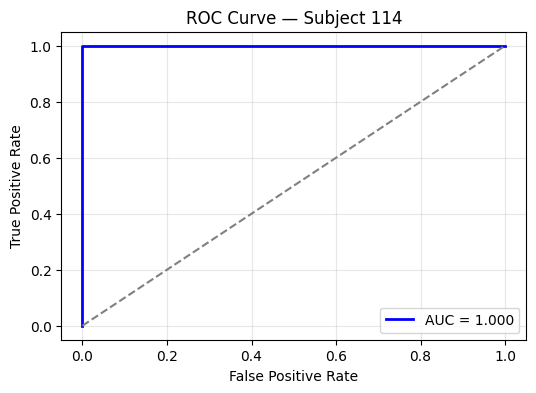

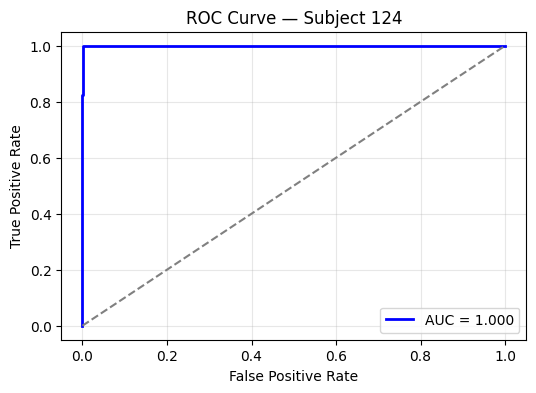

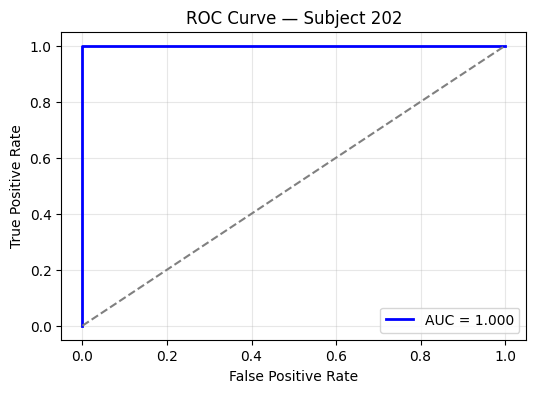

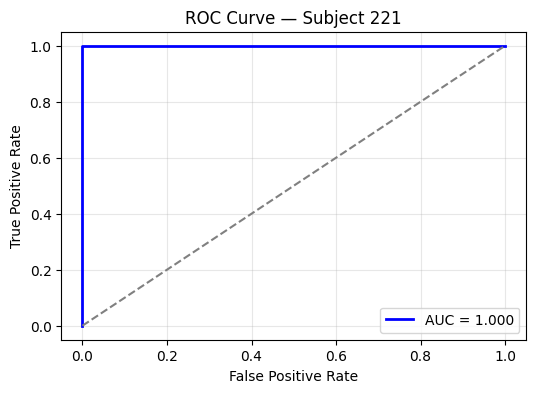

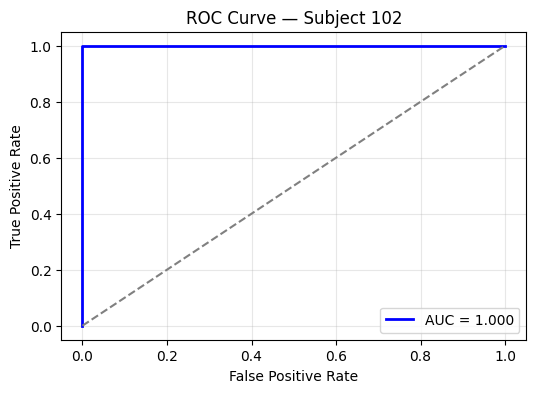


 Per-Subject Classification Results:



,Subject_ID,Accuracy,Precision,Recall,F1,AUC
0,114,0.9986,0.6667,1.0000,0.8000,1.0000
1,124,0.9986,0.9444,1.0000,0.9714,0.9997
2,202,1.0000,1.0000,1.0000,1.0000,1.0000
3,221,0.9986,0.5000,1.0000,0.6667,1.0000
4,102,0.9744,1.0000,0.6667,0.8000,1.0000


In [25]:
subject_results = []

# Loop through each subject
for rec in subjects:
    subj_df = df[df['Subject'] == rec].dropna(subset=['Target'])
    X_subj = subj_df.drop(columns=['Subject', 'Target'])
    y_subj = subj_df['Target'].astype(int)
    
    if len(np.unique(y_subj)) < 2:
        print(f"Skipping subject {rec} — only one class present.")
        continue
    
    # Scale using same scaler fitted earlier
    X_subj_scaled = scaler.transform(X_subj)
    
    # Predict using trained MLP model
    y_pred = mlp.predict(X_subj_scaled)
    y_prob = mlp.predict_proba(X_subj_scaled)[:, 1]
    
    # Classification metrics
    report = classification_report(y_subj, y_pred, output_dict=True, digits=3)
    accuracy = accuracy_score(y_subj, y_pred)
    auc_score = roc_auc_score(y_subj, y_prob)
    
    subject_results.append({
        "Subject_ID": rec,
        "Accuracy": accuracy,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1": report["1"]["f1-score"],
        "AUC": auc_score
    })
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_subj, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {auc_score:.3f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f"ROC Curve — Subject {rec}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Convert to DataFrame for summary
results_df = pd.DataFrame(subject_results)
print("\n Per-Subject Classification Results:\n")
display(results_df.round(4))


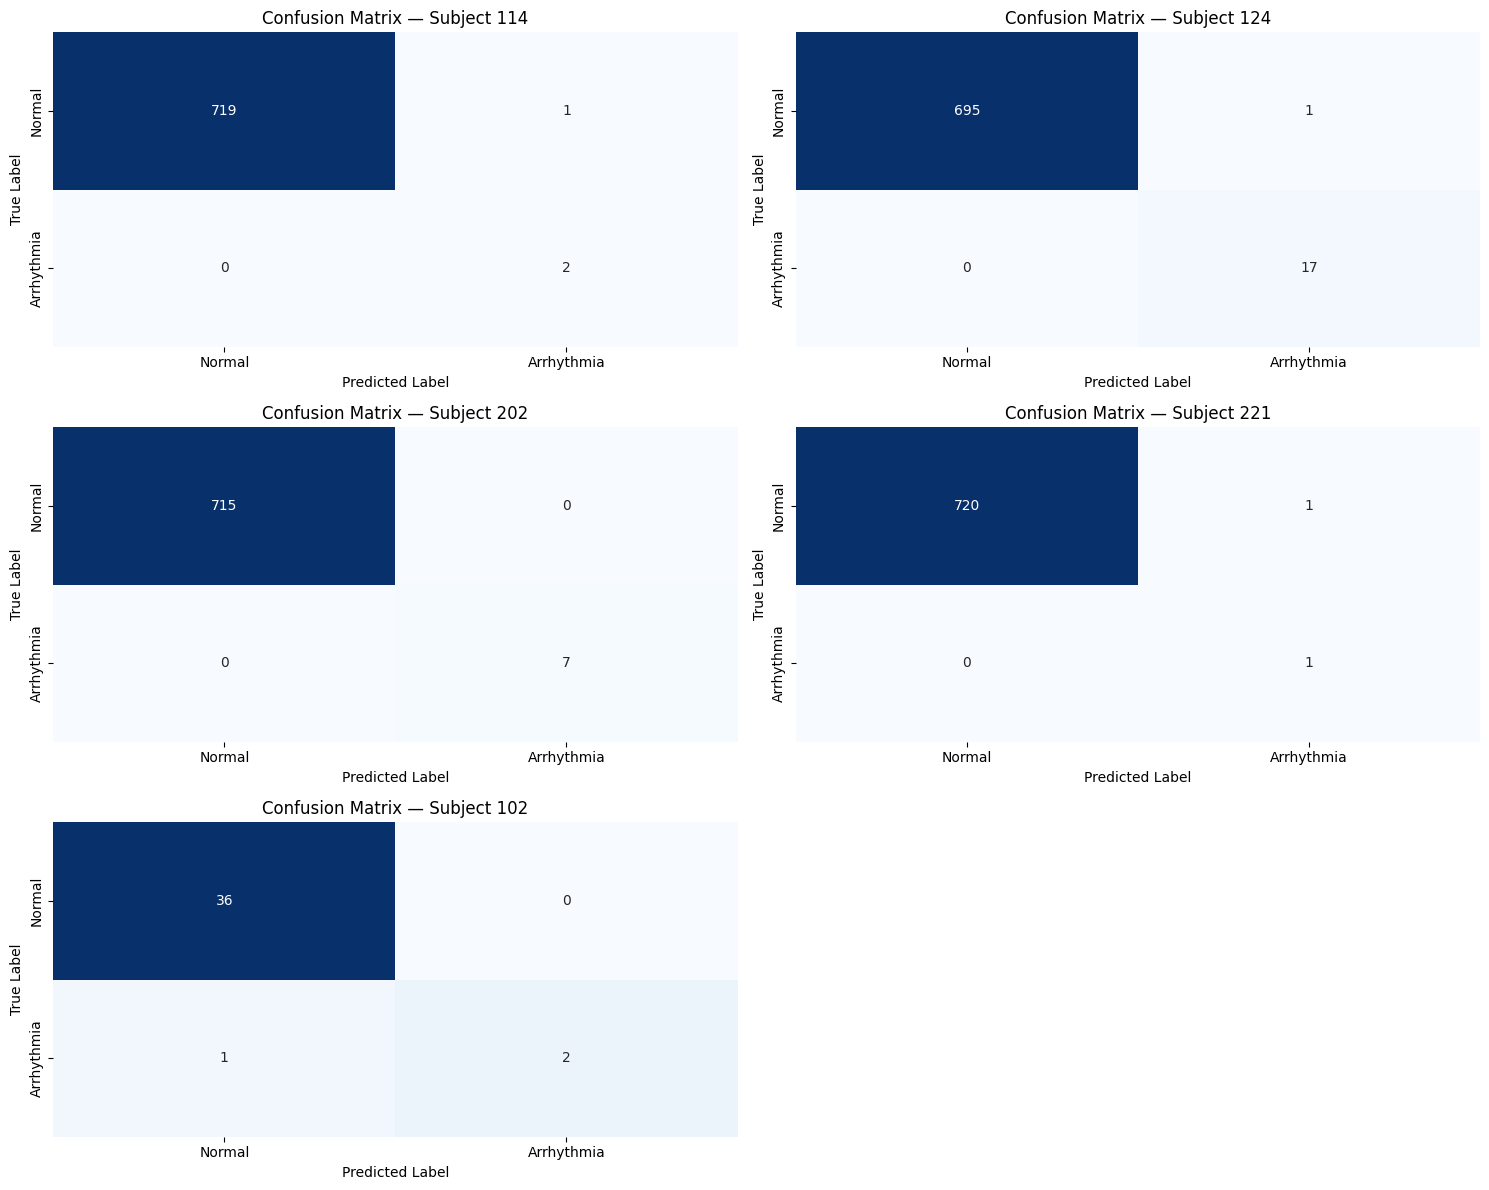

In [26]:
plt.figure(figsize=(15, 12))
plot_index = 1

for rec in subjects:
    subj_df = df[df['Subject'] == rec].dropna(subset=['Target'])
    X_subj = subj_df.drop(columns=['Subject', 'Target'])
    y_subj = subj_df['Target'].astype(int)

    # Skip subjects that have only one class
    if len(np.unique(y_subj)) < 2:
        print(f"Skipping subject {rec} — only one class present.")
        continue

    # Scale and predict
    X_subj_scaled = scaler.transform(X_subj)
    y_pred = mlp.predict(X_subj_scaled)

    # Compute confusion matrix
    cm = confusion_matrix(y_subj, y_pred)
    
    # Plot confusion matrix
    plt.subplot(3, 2, plot_index)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Arrhythmia'],
                yticklabels=['Normal', 'Arrhythmia'])
    plt.title(f"Confusion Matrix — Subject {rec}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
    plot_index += 1

plt.tight_layout()
plt.show()

# Optional 

In [27]:
# --- Compare Single-Layer NN and Multi-Layer Perceptron ---

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

models = {
    "Single-Layer NN": MLPClassifier(hidden_layer_sizes=(10,), activation='relu', 
                                     solver='adam', max_iter=500, random_state=42),
    "Multi-Layer NN": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                                    solver='adam', alpha=0.001, learning_rate='adaptive',
                                    max_iter=1000, random_state=42)
}

comparison_results = []

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    }
    comparison_results.append(metrics)

comparison_df = pd.DataFrame(comparison_results)
print("\nModel Performance Comparison:\n")
display(comparison_df.round(4))



Model Performance Comparison:



,Model,Accuracy,Precision,Recall,F1,AUC
0,Single-Layer NN,0.9743,0.2353,0.6667,0.3478,0.9925
1,Multi-Layer NN,0.9932,0.6250,0.8333,0.7143,0.9983


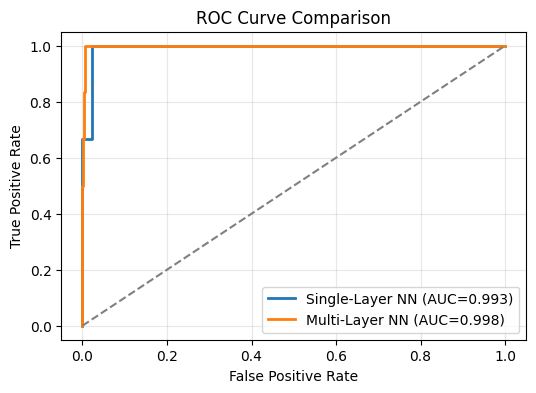

In [28]:
plt.figure(figsize=(6,4))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


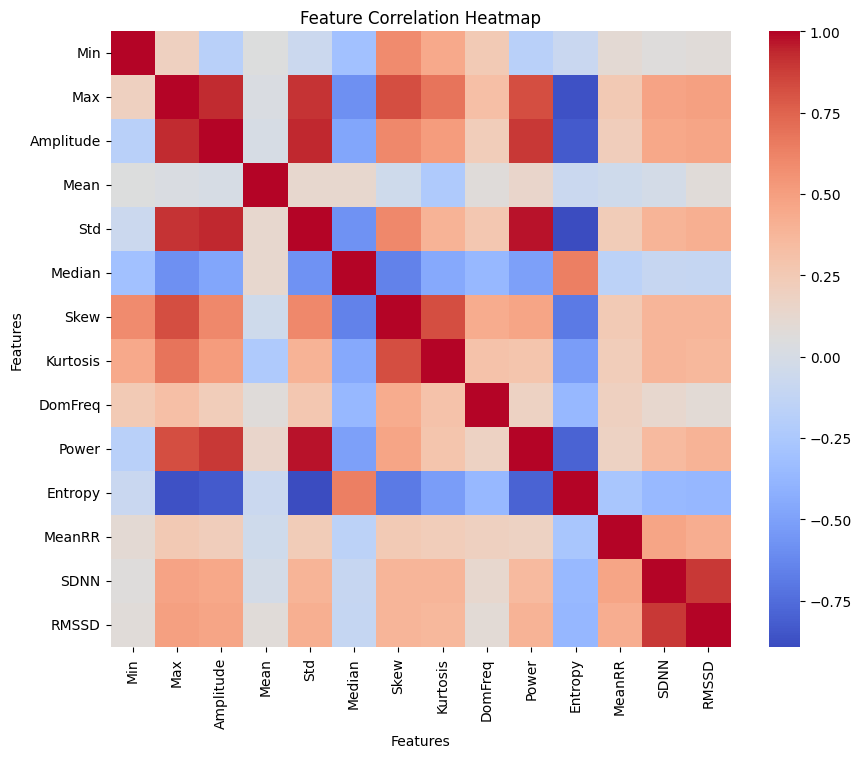

In [29]:
plt.figure(figsize=(10,8))
corr = pd.DataFrame(X_scaled, columns=X.columns).corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()


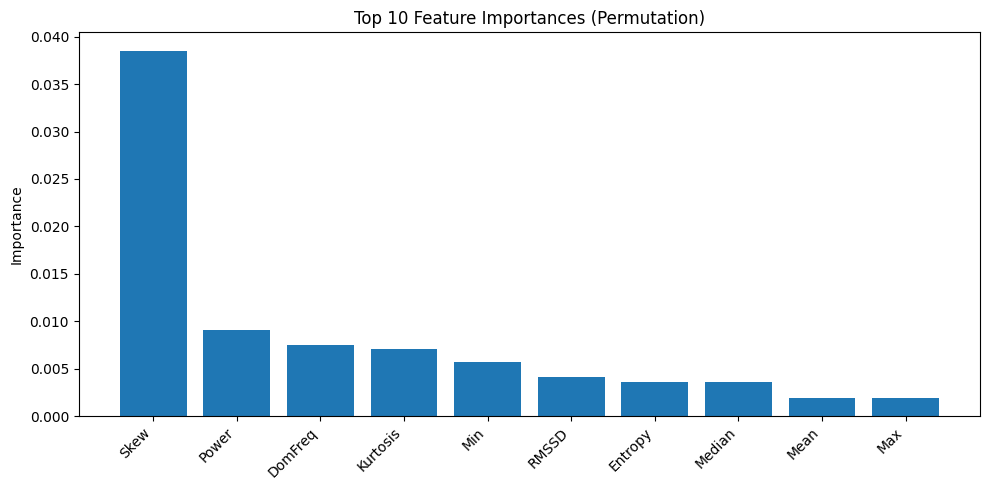

In [30]:
from sklearn.inspection import permutation_importance
perm = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm.importances_mean.argsort()[::-1]

plt.figure(figsize=(10,5))
plt.bar(range(10), perm.importances_mean[sorted_idx[:10]])
plt.xticks(range(10), np.array(X.columns)[sorted_idx[:10]], rotation=45, ha='right')
plt.title("Top 10 Feature Importances (Permutation)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

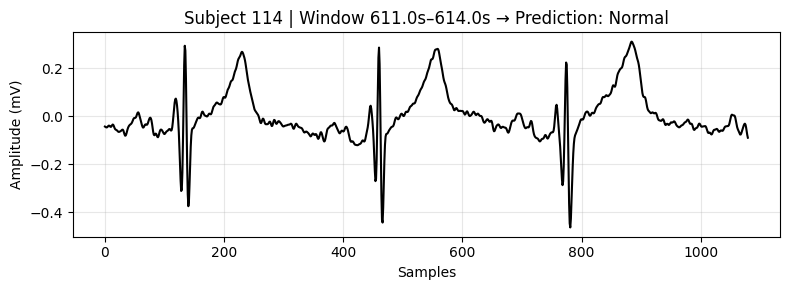

In [ ]:
import time
from IPython.display import clear_output

# Choose one subject
rec = '114'
signal = records[rec]['filtered']
fs = records[rec]['fs']
win_sec = 3
step_sec = 1

win_len = int(fs * win_sec)
step_len = int(fs * step_sec)

print(f"Real-time simulation on Subject {rec} with {win_sec}s window, {step_sec}s step...")

for start in range(0, len(signal) - win_len, step_len):
    window = signal[start:start + win_len]
    feats = extract_features([window], fs)
    X_live = scaler.transform(feats)
    pred = mlp.predict(X_live)[0]
    label = "Arrhythmia" if pred == 1 else "Normal"

    clear_output(wait=True)
    plt.figure(figsize=(8, 3))
    plt.plot(window, color='black')
    plt.title(f"Subject {rec} | Window {start//fs:.1f}s–{(start+win_len)//fs:.1f}s → Prediction: {label}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    time.sleep(0.5)  # simulate streaming speed
